In [74]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import h5py
import seaborn as sns
import sys
import platform

if platform.system() == "Darwin":
    neuropy_path = Path('/Users/nkinsky/Documents/UM/GitHub/NeuroPy')
    eraser_path = Path('/Users/nkinsky/Documents/BU/GitHub/Eraser')
elif platform.system() == "Linux":
    neuropy_path = Path('/data/GitHub/NeuroPy')
    eraser_path = Path('/data/GitHub/Eraser')
sys.path.append(str(neuropy_path))
sys.path.append(str(eraser_path))
%load_ext autoreload
%autoreload 2

from neuropy.utils.ccg import correlograms
from neuropy.utils.mathutil import contiguous_regions
from neuropy.io.openephysio import get_dat_timestamps, get_lfp_timestamps, create_sync_df, recording_events_to_combined_time
from neuropy.plotting import Fig
from neuropy.io.binarysignalio import BinarysignalIO
from neuropy.plotting.signals import plot_signal_traces
from neuropy.utils.signal_process import filter_sig

# Eraser github imports
from Ephys.ephys import *
# from plotting import Fig, pretty_plot, FigMirror

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [78]:
# Set Data and Figure Directories
# Needs to be set for each PC
fig_save_dir = Path('/data3/Anisomycin/Recording_Rats/Creampuff')
working_dir = Path('/data3/Anisomycin/Recording_Rats/Creampuff')

In [3]:
FigS7 = Fig(4, 5, num="Figure S7_2", size=(7, 3), fontsize=6)
print(FigS7.fig.get_size_inches())

[7. 3.]


<Figure size 700x300 with 0 Axes>

In [4]:
saline1_folder = '2024_07_15_Saline1'
ani_folder = '2024_07_17_Anisomycin'
saline2_folder = '2024_07_18_Saline2'

folder_list = [saline1_folder, ani_folder, saline2_folder]
unit_type = ['single', 'single', 'single']
session = ['saline1', 'ANI', 'saline2']

In [46]:
# ani_timestamps = get_dat_timestamps(working_dir / ani_folder)
ani_timestamps = get_lfp_timestamps(working_dir / ani_folder)

OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
start time = 2024-07-17 10:12:28-04:00
start time = 2024-07-17 10:18:16-04:00
start time = 2024-07-17 10:26:56-04:00
start time = 2024-07-17 10:34:03-04:00
start time = 2024-07-17 10:42:12-04:00
start time = 2024-07-17 12:21:10-04:00
start time = 2024-07-17 12:56:44-04:00
start time = 2024-07-17 14:12:18-04:00


### Sanity check plot - should be a 1/1 line approximately

In [ ]:
%matplotlib widget
_, ax = plt.subplots()
ax.plot(dt.reset_index()[0].dt.total_seconds())

In [114]:
ani_epochs = load_events_csv(ani_folder, ani_timestamps.iloc[0], working_dir=working_dir)
ani_epochs["start"] = ani_epochs["start"].dt.tz_localize("America/Detroit")
ani_epochs["stop"] = ani_epochs["stop"].dt.tz_localize("America/Detroit")
ani_epochs

,start,stop,label
0,2024-07-17 10:12:29-04:00,2024-07-17 10:39:00-04:00,pre
1,2024-07-17 10:40:30-04:00,2024-07-17 10:41:00-04:00,ANI
2,2024-07-17 10:42:13-04:00,2024-07-17 12:20:00-04:00,post
3,2024-07-17 12:21:11-04:00,2024-07-17 12:55:00-04:00,track1
4,2024-07-17 12:56:45-04:00,2024-07-17 14:11:30-04:00,post2
5,2024-07-17 14:12:19-04:00,2024-07-17 14:22:00-04:00,track2


In [52]:
corr_by_epoch_ani, time_bins_ani, epochs_used_ani = calc_ccg_by_epoch(ani_folder, timestamps=ani_timestamps, working_dir=working_dir)

Calculating CCGs for epoch pre
0   2024-07-17 10:12:27
Name: start, dtype: datetime64[ns]_0   2024-07-17 10:40:00
Name: stop, dtype: datetime64[ns]
start_sec=[0.], stop_sec=[60.30233333]
test
Calculating CCGs for epoch ANI
1   2024-07-17 10:40:30
Name: start, dtype: datetime64[ns]_1   2024-07-17 10:41:00
Name: stop, dtype: datetime64[ns]
start_sec=[60.30233333], stop_sec=[60.30233333]
Calculating CCGs for epoch post
2   2024-07-17 10:42:12
Name: start, dtype: datetime64[ns]_2   2024-07-17 12:10:00
Name: stop, dtype: datetime64[ns]
start_sec=[60.30233333], stop_sec=[279.80233333]
test
Calculating CCGs for epoch track1
3   2024-07-17 12:21:10
Name: start, dtype: datetime64[ns]_3   2024-07-17 12:56:00
Name: stop, dtype: datetime64[ns]
start_sec=[306.79086667], stop_sec=[392.96473333]
test
Calculating CCGs for epoch post2
4   2024-07-17 12:56:44
Name: start, dtype: datetime64[ns]_4   2024-07-17 14:11:30
Name: stop, dtype: datetime64[ns]
start_sec=[392.96473333], stop_sec=[579.8814]
test
Ca

In [68]:
# Plot all cells
# for idn in range(corr_by_epoch_ani.shape[2]):
#     fig, ax = plt.subplots(1, 5, figsize=(8, 2))
#     plot_ccg_by_epoch(corr_by_epoch_ani[:, idn, idn, :].reshape((corr_by_epoch_ani.shape[0], 1, 1, corr_by_epoch_ani.shape[3])), 
#                   time_bins_ani, epochs_used_ani, 'ANI combined', ax=ax[None, :])
#     fig.suptitle(idn)

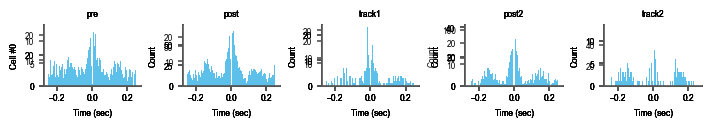

In [67]:
# Plot ACGs
ax_saline2 = []
for i in range(5):
    ax_saline2.append(FigS7.subplot(FigS7.gs[0, i]))
ax_saline2 = np.array(ax_saline2)[None, :]
plot_ccg_by_epoch(corr_by_epoch_ani[:, 10, 10, :].reshape((corr_by_epoch_ani.shape[0], 1, 1, corr_by_epoch_ani.shape[3])), 
                  time_bins_ani, epochs_used_ani, 'ANI combined', ax=ax_saline2)

FigS7.fig

### Import eeg file and get raw theta and SWR traces

In [139]:
# Find EEG file and get Theta/SWR signals
sorted((working_dir / ani_folder).glob("*.eeg"))[0]
ani_signal = BinarysignalIO(sorted((working_dir / ani_folder).glob("*.eeg"))[0], n_channels=35, sampling_rate=1250).get_signal()
print(ani_signal)

In [136]:
sync_df = create_sync_df(working_dir / ani_folder)

OE version >= 0.6 detected, check timestamps. Could be off by factor = Sampling Rate
start time = 2024-07-17 10:12:28-04:00
start time = 2024-07-17 10:18:16-04:00
start time = 2024-07-17 10:26:56-04:00
start time = 2024-07-17 10:34:03-04:00
start time = 2024-07-17 10:42:12-04:00
start time = 2024-07-17 12:21:10-04:00
start time = 2024-07-17 12:56:44-04:00
start time = 2024-07-17 14:12:18-04:00


In [135]:
event_starts = recording_events_to_combined_time(ani_epochs, sync_df, event_ts_key="start")
event_stops = recording_events_to_combined_time(ani_epochs, sync_df, event_ts_key="stop")
ani_epochs.loc[[0, 2, 3, 4, 5], ["eeg_start", "eeg_stop"]] = np.vstack((event_starts, event_stops)).T
ani_epochs

,start,stop,label,eeg_start,eeg_stop
0,2024-07-17 10:12:29-04:00,2024-07-17 10:39:00-04:00,pre,1.0000,1443.1720
1,2024-07-17 10:40:30-04:00,2024-07-17 10:41:00-04:00,ANI,NaN,NaN
2,2024-07-17 10:42:13-04:00,2024-07-17 12:20:00-04:00,post,1448.2560,7315.2560
3,2024-07-17 12:21:11-04:00,2024-07-17 12:55:00-04:00,track1,7363.9808,9392.9808
4,2024-07-17 12:56:45-04:00,2024-07-17 14:11:30-04:00,post2,9432.1536,13917.1536
5,2024-07-17 14:12:19-04:00,2024-07-17 14:22:00-04:00,track2,13951.4320,14532.4320


(-2.3753182241539896, 1.9065197143744181)

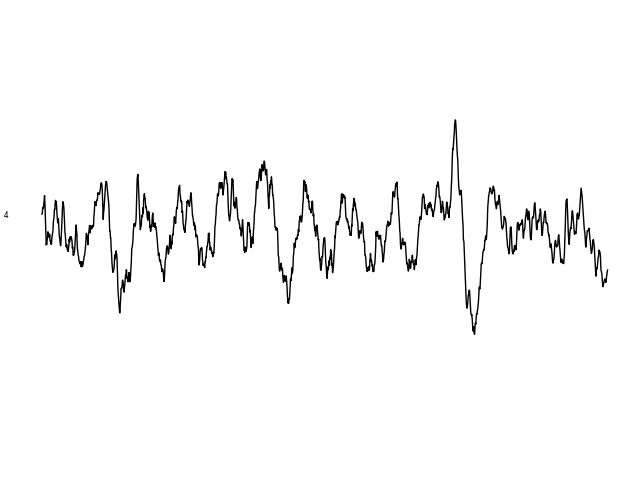

In [142]:
# Make sure it is working well by plotting
# pre_theta = get_epoch_signal(saline2_signal, 'Pre', saline2_epochs, channel_indx=4)
ax = plot_signal_traces(ani_signal.time_slice(t_start=20.5, t_stop=22.4, channel_id=4))
ax.set_ylim(np.array(ax.get_ylim())*2)

In [153]:
ani_signal.time_slice(t_start=(47*60 + 19.8), t_stop=(47*60 + 21.6), channel_id=4)

In [150]:
ax_theta = FigS7.subplot2grid(FigS7.gs[1:, 0:3], grid=(4, 1), return_axes=True)


In [157]:
ax_theta[0].set_yticks()

TypeError: Axis.set_ticks() missing 1 required positional argument: 'ticks'

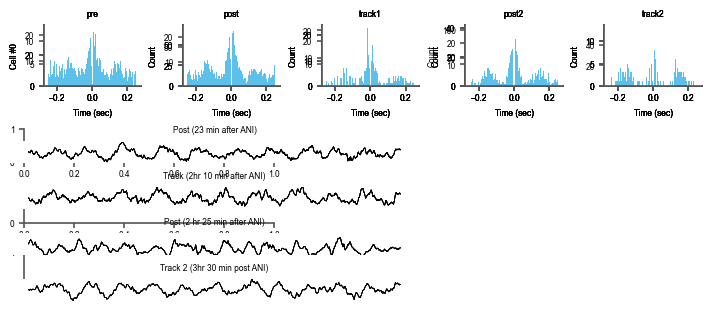

In [161]:
# Post
plot_signal_traces(ani_signal.time_slice(t_start=(47*60 + 19.8), t_stop=(47*60 + 21.6), channel_id=4), ax=ax_theta[0], lw=0.5)
ax_theta[0].set_title('Post (23 min after ANI)')

# Track1
plot_signal_traces(ani_signal.time_slice(t_start=(156*60 + 18.2), t_stop=(156*60 + 20.1), channel_id=4), ax=ax_theta[1], lw=0.5)
ax_theta[1].set_title('Track (2hr 10 min after ANI)')
ax_theta[1].sharey(ax_theta[0])

# Post 2
plot_signal_traces(ani_signal.time_slice(t_start=(171*60 + 23.8), t_stop=(171*60 + 26.3), channel_id=4), ax=ax_theta[2], lw=0.5)
ax_theta[2].set_title('Post (2 hr 25 min after ANI)')
ax_theta[2].sharey(ax_theta[0])

ax_theta[2].set_ylim(np.array(ax_theta[2].get_ylim())*1.6)

# Track 2
plot_signal_traces(ani_signal.time_slice(t_start=(233*60 + 26.4), t_stop=(233*60 + 28.3), channel_id=4), ax=ax_theta[3], lw=0.5)
ax_theta[3].set_title('Track 2 (3hr 30 min post ANI)')
ax_theta[3].sharey(ax_theta[0])


ax_theta[0].set_ylim((-1, 1))
[sns.despine(ax=a, left=True, bottom=True) for a in ax_theta];
[a.set_yticks([]) for a in ax_theta];
[a.set_xticks([]) for a in ax_theta];
FigS7.fig


In [164]:
from neuropy.core.session import ProcessData

sess = ProcessData(working_dir / ani_folder)
print(sess.recinfo)

filename: /data3/Anisomycin/Recording_Rats/Creampuff/2024_07_17_Anisomycin/Creampuff_anisomycin.xml 
# channels: 35
sampling rate: 30000
lfp Srate (downsampled): 1250



In [165]:
from neuropy.io.phyio import PhyIO
from neuropy.core.neurons import Neurons
phy_dir = sorted(sess.basepath.glob("**/params.py"))[0].parent
sess.phy = PhyIO(dirname=phy_dir)

sess.neurons = Neurons(sess.phy.spiketrains, t_stop=sess.eegfile.duration, neuron_ids=sess.phy.neuron_ids,
                       neuron_type=sess.phy.cluster_info["group"], waveforms=sess.phy.waveforms, 
                       waveforms_amplitude=sess.phy.waveforms_amplitude, sampling_rate=sess.recinfo.dat_sampling_rate,
                       peak_channels=sess.phy.peak_channels, shank_ids=sess.phy.shank_ids)

# 
# for sh in np.unique(sess.neurons.shank_ids.astype(int)):
#     sess.recinfo.write_neurons(sess.neurons.neuron_slice(np.where(sess.neurons.shank_ids == sh)[0]), suffix_num=sh)

id column does not exist in cluster_info.tsv. Using cluster_id column instead.


In [166]:
sess.neurons

Neurons
 n_neurons: 21
 t_start: 0.0
 t_stop: 15859.7144
 neuron_type: ['good']

# Get Spikes/Probe Group, Not Necessary after running once

In [ ]:
from neuropy.analyses.spkepochs import detect_pbe_epochs
bin_size=0.01
thresh = (2.5, None)
edge_cutoff = 0.5
duration = (0.1, None)
distance = None

# Collect MUA
sess.mua = sess.neurons.get_mua(bin_size=bin_size)

In [ ]:
# Detect PBEs
sess.pbe = detect_pbe_epochs(sess.mua, thresh=thresh, edge_cutoff=edge_cutoff, duration=duration, distance=distance)
pbe_epochs_file = sess.filePrefix.with_suffix(".pbe_epochs.npy")
sess.pbe.save(pbe_epochs_file)
sess.recinfo.write_epochs(sess.pbe, ext='pbe')

In [ ]:
from neuropy.core.session import ProcessData
import os

def sess_use(basepath=os.getcwd()):
    return ProcessData(basepath)

sess = sess_use('/media/kimqi/BK/Data/Anisomycin/Recording_Rats/Creampuff/2024_07_18_Saline2')
print(sess.recinfo)

signal = sess.eegfile.get_signal()

In [ ]:
from neuropy.core import Shank, Probe, ProbeGroup
from neuropy.plotting import plot_probe
shank = Shank()
shank = shank.auto_generate(columns=4, contacts_per_column=8, xpitch=125,
                   ypitch=-20, channel_id=np.arange(0, 32, 1))
shank.set_disconnected_channels(sess.recinfo.skipped_channels)
probe = Probe(shank)
prbgrp = ProbeGroup()
prbgrp.add_probe(probe)
plot_probe(prbgrp)
prbgrp.filename = sess.filePrefix.with_suffix(".probegroup.npy")
prbgrp.save(prbgrp.filename)
sess.prbgrp = prbgrp

In [ ]:
art_epochs_file = sess.filePrefix.with_suffix(".art_epochs.npy")
art_epochs = Epoch(epochs=None, file=art_epochs_file)

In [ ]:
# Detect Ripple Epochs
ripple_epochs = oscillations.detect_ripple_epochs(signal, sess.prbgrp, thresh=(2.5,5), ignore_epochs=art_epochs, ripple_channel=17)

In [ ]:
ripple_epochs_file = sess.filePrefix.with_suffix(".ripple_epochs.npy")
sess.recinfo.write_epochs(epochs=ripple_epochs, ext='swr')
ripple_epochs.save(ripple_epochs_file)

## Now grab some ripples

In [171]:
237 - 1443/60

212.95

In [ ]:
fig, ax = plt.subplots(2, 1, height_ratios=[1, 5], sharex=True)

swr_track = get_epoch_signal(sali_signal, 'Track 1', saline2_epochs, channel_indx=[16])
swr_ax = plot_signal_traces(swr_track.time_slice(t_start=6028.26, t_stop=6029.26), ax=ax[0])

spikes.plot_raster(sess.neurons.time_slice(t_start=6028.26, t_stop=6029.26), ax=ax[1], markersize=8)
sns.despine(ax=ax[1], bottom=True, left=True)
ax[1].set_xticks([])

ax[1].set_yticks([])

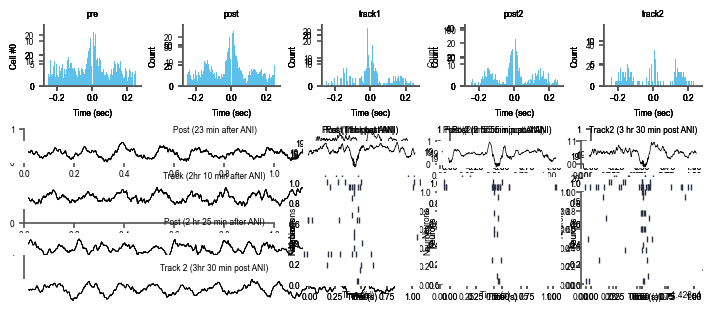

In [176]:
from neuropy.plotting.spikes import plot_raster
# Get Signals for various epochs to look for ripples
# swr_track = get_epoch_signal(saline2_signal, 'Track 1', saline2_epochs, channel_indx=[16])
# swr_post = get_epoch_signal(saline2_signal, 'Post', saline2_epochs, channel_indx=[16])
# swr_track2 = get_epoch_signal(saline2_signal, 'Track 2', saline2_epochs, channel_indx=[16])

ax_swr = FigS7.subplot2grid(FigS7.gs[1:, 2:], height_ratios=[1, 4], grid=(2, 3), return_axes=True)

# Plot Post 1 LFP and Spikes
t_start, t_stop = 85*60 + 12.2, 85*60 + 13.2
plot_signal_traces(ani_signal.time_slice(t_start=t_start, t_stop=t_stop, channel_id=19), ax=ax_swr[0, 0], lw=0.5)
plot_raster(sess.neurons.time_slice(t_start=t_start, t_stop=t_stop), ax=ax_swr[1,0], markersize=4)
sns.despine(ax=ax_swr[1,0], bottom=True, left=True)
ax_swr[1,0].set_xticks([])
ax_swr[1,0].set_yticks([])
ax_swr[0,0].set_title('Post (1 hr post ANI)')

# Plot Post 2
t_start, t_stop = 192*60 + 58.3, 192*60 + 59.3
plot_signal_traces(ani_signal.time_slice(t_start=t_start, t_stop=t_stop, channel_id=19), ax=ax_swr[0, 1], lw=0.5)
plot_raster(sess.neurons.time_slice(t_start=t_start, t_stop=t_stop), ax=ax_swr[1,1], markersize=4)
sns.despine(ax=ax_swr[1,1], bottom=True, left=True)
ax_swr[1,1].set_xticks([])
ax_swr[1,1].set_yticks([])
ax_swr[0,1].set_title('Post (2 hr 55 min post ANI)')

# Plot Track 2 LFP and Spikes
t_start, t_stop = 237*60 + 11.4, 237*60 + 12.4
plot_signal_traces(ani_signal.time_slice(t_start=t_start, t_stop=t_stop, channel_id=19), ax=ax_swr[0,2], lw=0.5)
plot_raster(sess.neurons.time_slice(t_start=t_start, t_stop=t_stop), ax=ax_swr[1,2], markersize=4)
sns.despine(ax=ax_swr[1,2], bottom=True, left=True)
ax_swr[1,2].set_xticks([])
ax_swr[1,2].set_yticks([])
ax_swr[0,2].set_title('Track2 (3 hr 30 min post ANI)')

FigS7.fig

In [177]:
FigS7.savefig(fig_save_dir / 'Figure S7_Rat2_ani.pdf')

In [175]:
fig_save_dir

PosixPath('/data3/Anisomycin/Recording_Rats/Creampuff')